# Testing a stock buying strategy versus buying and holding a stock

An analysis by Daniel Peletski and William Reid

Published December 21, 2020, 
Last Updated December 21, 2020

# INTRODUCTION

William's freshman year of college included a class about personal finance and the stock market. He took an interest in the stock market porition in the class as would any college student looking to make some money. This class gave a lot of information about the stock market in general and the technique of technical analysis with the stock market. According to investopedia.com, technical analysis is "a trading discipline employed to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume." The technical analysis taught provided multiple ways of evaluating the stock market as a whole and evaluating individual stocks. Inside the evaluation of an individual stock included numerous approaches to buying a stock with an entry setup. An entry setup is an indicator that the trader looks for and when the indicator occurs then it is usually a good indication that the trader should buy the stock. These indicators are usually created using the statistic side of a side and all the data that comes with it.  

The entry setup and indicator used in this project was called a 'Green Dot Bounce' in this class as we would put green dots on the chart as the indicator. This green dot indicator was created using the stochastic of the stock. Investopeia states "the stochastic oscillator presents the location of the closing price of a stock in relation to the high and low range of the price of a stock over a period of time." We were taught the period of time this is calculated over is a 10 day period but every trader using this calculation may use different time periods. The main stochastic creates one line that can be plotted and typically a rolling average is also plotted on the same graph. Again the time period of the rolling average will depend on the trader but we were taught to use a 4 day rolling average. The crossing of these two lines will create the indicator. When the main stochastic crossing the rolling average then a 'green dot bounce' is created and this may be a good signal for the trader to buy the stock. This is the strategy we are going to test in this project.

The finance class also strongly suggested to use a trailing stop loss in order to cut losses or take gains before the stock plummets. The class taught to use a 8% trailing stop loss. This means that if the stock drops below 8% under the purchase price then we need to sell the stock. The trailing part of the stop loss means that the stop loss follows the stock as the price incresaes. So if the stock rises in price then so will the stop loss but if the stock falls in price then the stop loss will remain the same.

# WHAT AND HOW WE ARE TESTING

This project will test the effectiveness of the 'green dot bounce' as a stock buying strategy. To test the effectiveness of this we will compare it against buying and holding the stock during the same time period. We will 'buy' the stock the first day the 'green dot bounce' occurs and sell the stock if it falls below the trailing stop loss. We will run this strategy on the over 500 stocks in the S&P 500 over a INSERT TIME PERIOD. Our analysis will include how many times the strategy out performed the buy and hold of the stock, the average gain/loss of the strategy and other metrics. 

# HOW WE COLLECTED DATA

To find the 500 or so stocks in the S&P 500 we scraped a website which had a table of the stocks. This website was https://www.slickcharts.com/sp500. We got the HTML code of the website and then searched for the table, put the table into a dataframe, and then created a list of stock symbols from the dataframe. This list of stock symbols that we created is what we are going to use for this analysis.

In [1]:
import requests # for GET requests
from bs4 import BeautifulSoup # easier to read HTML code
import pandas as pd # used for multiple dataframes
import numpy as np
import datetime as dt # datetime objects used
import yfinance as yf # yahoo finance, which provides the data on each stock
from pandas_datareader import data as pdr # used to put stock data into dataframe
import matplotlib.pyplot as plt  # allow for plots to be made to show data


yf.pdr_override()

# Get html code of website that has stock list for S&P 500
url = 'https://www.slickcharts.com/sp500'
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36'}
r = requests.get(url, headers = headers)
soup = BeautifulSoup(r.text, 'html')

# Find the table holding the list of stocks
table = soup.find('table') # Find all the tables on the web page
temp = pd.read_html(table.prettify()) # Get the list of tables on the page
sp = pd.DataFrame(temp[0]) # Put the table of stocks into a dataframe

# Put the stock symbols into one list
stockList = [] # List of all the stocks we are using
for idx, row in sp.iterrows():
    sym = row['Symbol'] # Get the symbols of the stocks we are going to use
    sym = sym.replace('.','-') # Fix the name of the stock for yfinance to accept it
    stockList.append(sym)




# HOW WE CALCULATED RETURNS

Creating the 'green dot bounce' metric was done by following investopedia's article about the stochastic oscillator, https://www.investopedia.com/terms/s/stochasticoscillator.asp. We had created two columns in the dataframe of stock data for the low and high of the past 10 days. Next, we calculated %K as the current stock price as a percentage of the past 10 days. And %D is the rolling 4 day average of the %K metric. 

To find out when to buy the stock with the 'green dot bounce' we created another column in the dataframe called 'Buy Entry' which is a boolean indicator that tells us when the %K is crossing above the %D and the %D is below 25. These are the elements taught in the class that make a 'green dot bounce'.

We next iterate through the dataframe to find out when we buy and sell the stock. We have a placeholder value ('own') to represent if we own the stock at the current time. Then we also keep track of our stop loss, the previous day's close, the return on the current position, and a list of returns if we buy the stock multiple times. We then use different conditions to determine when we buy the stock, when we sell the stock, and to update the stoploss as it is a trailing stop loss. 

At the end we check to make sure the dataframe of stock data is not empty as some times the stock does not have enough information for us to use as it could have been created very recently. We sum up all the returns from the stock during the time period, calculate the return of the straight stock, and then put these elements in a new dataframe which contains the return data of all the stocks.

In [2]:
# Set up time objects
now = dt.datetime.now()
end = dt.datetime(now.year,now.month-2,now.day)
start = dt.datetime(now.year, now.month-4, now.day)

totReturns = [] # list of strategy returns
totStraight = [] # list of straight stock returns
usedStocks = [] # list of stocks that we could gather data from
# Go through each stock in list and test the purchasing setup
for stock in stockList:
    df = pdr.get_data_yahoo(stock,start,end) # Get all the stock data into a data frame using yfinance

    # Get rid of columns that are not of use and only taking up space
    df.drop('Open', inplace=True, axis=1)
    df.drop('Close', inplace=True, axis=1)
    df.drop('Volume', inplace=True, axis=1)

    # Create column of rolling highs and lows (High/Low over past 10 days)
    df['L10'] = df['Low'].rolling(window=10).min()
    df['H10'] = df['High'].rolling(window=10).max()

    # Calculate %K and %D (part of stochastic measure)
    df['%K'] = 100*((df['Adj Close'] - df['L10']) / (df['H10'] - df['L10']))
    df['%D'] = df['%K'].rolling(window=4).mean()

    # Column to determine when to buy the stock 
    # (if %K crosses through %D line and %D < 20)
    df['Buy Entry'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < 25)

    # Initialize Long to 0
    df['Long'] = 0

    own = 0 # Binary representation if we 'own' the stock or not during the time period
    stopLoss = 0 # The price at which we will sell the stock
    prevClose = 0 # The close of the previous day
    tempRet = 0 # Temporary returns on the position
    returns = [] # List of gain/loss for eachs stock
    for idx, row in df.iterrows():
        if row['Buy Entry'] and own == 0:
            # Buy the stock
            own = 1
            df['Long'][idx] = 1
            stopLoss = 0.92 * row['Adj Close'] # Calculate the stop loss (8% below price)
            tempRet = 0 # Initialize the return for current position
        elif stopLoss > row['Adj Close']:
            # Sell the stock
            own = 0
            df['Long'][idx] = 0
            stopLoss = 0 # Reset the stop loss
            returns.append(tempRet) # Add the position's return to list
            tempRet = 0 # Reset the temporary return
        elif own == 1:
            # Check if we need to update our stop loss
            df['Long'][idx] = 1
            tempRet = tempRet + (100 * (row['Adj Close'] - prevClose) / prevClose)
            tempStopLoss = 0.92 * row['Adj Close'] # Calculate temporary stop loss
            if tempStopLoss > stopLoss: # Only change stop loss if new one > old one
               stopLoss = tempStopLoss
        prevClose = row['Adj Close']

    returns.append(tempRet) # Add the final return to total return (if holding position at end of time period)

    if not(df.empty): # Check if stock had usable data and add those totals to lists
        totReturns.append(sum(returns))
        totStraight.append(100* (df['Adj Close'].iloc[-1] - df['Adj Close'].iloc[0]) / df['Adj Close'].iloc[0])
        usedStocks.append(stock)

# Create dataframe of the stock symbol and returns
# Using the lists from the loop
data = pd.DataFrame()
data['Stock'] = usedStocks
data['Strategy Return'] = totReturns
data['Stock Return'] = totStraight

************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*

Data is the dataframe that has each stock's strategy return and the straight stock return.

In [3]:
data

,Stock,Strategy Return,Stock Return
0,AAPL,2.472577,2.862821
1,MSFT,4.297370,4.749649
2,AMZN,4.412593,0.375098
3,FB,-0.760787,1.271943
4,GOOGL,5.089946,1.494874
...,...,...,...
500,HFC,-1.326022,-22.162165
501,UAA,0.000000,30.260527
502,UA,0.000000,25.277158
503,NWS,-2.281933,-7.984807


In [12]:
# Get number of times strategy was better than the straight stock
count = 0
stratNeg = 0
straightNeg = 0
for index, row in data.iterrows():
    if row['Strategy Return'] > row['Stock Return']:
        count = count + 1
    if row['Strategy Return'] < 0:
        stratNeg = stratNeg + 1
    if row['Stock Return'] < 0:
        straightNeg = straightNeg + 1

print('# of times strategy beat straight stock: '+str(count))
print('Times that strategy ended negative: '+str(stratNeg))
print('Times that straight stock ended negative: '+str(straightNeg))

# of times strategy beat straight stock: 327
Times that strategy ended negative: 73
Times that straight stock ended negative: 171


327/505

In [9]:
#Get average gain/loss of strategy and straight stock
print('Average Strategy Return: '+str(data['Strategy Return'].mean()) +'%')
print('Average Straight Stock Return: '+str(data['Stock Return'].mean())+'%')

Average Strategy Return: 5.62258322945644%
Average Straight Stock Return: 3.627190369323734%


<AxesSubplot:title={'center':'Strategy Return vs. Stock Return'}, xlabel='Strategy Return', ylabel='Stock Return'>

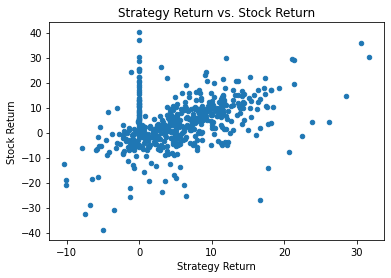

In [6]:
#Create a scatterplot of startegy returns vs. stock returns
import matplotlib.pyplot as plt
data.plot(x = 'Strategy Return',y='Stock Return', kind = 'scatter', title = 'Strategy Return vs. Stock Return')

# ANALYSIS

As calculated above, the 'green dot bounce' strategy outperformed the straight stock 327 times out of 505 stocks, which is about 64.75% of the time. The average strategy return was about 5.62% versus the straight stock average return of 3.63%. The straight stock ended negative about 100 times more than the strategy did. 